# Probabilistic Forecasting: Bootstrapped Residuals

Forecasting intervals with bootstrapped residuals is a method used to estimate the uncertainty in predictions by resampling past prediction errors (residuals). The goal is to generate prediction intervals that capture the variability in the forecast, giving a range of possible future values instead of just a single point estimate.

The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Diagram bootstrapping prediction process.</i></font>
</p>

Repeatedly performing this process creates a collection of slightly different predictions, which represent the distribution of possible outcomes due to the expected variance in the forecasting process.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Bootstrapping predictions.</i></font>
</p>

Using the outcome of the bootstrapping process, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles at each forecasting horizon. 

<p style="text-align: center">
<img src="../img/forecasting-intervals.gif" style="width: 800px;">
</p>

Alternatively, it is also possible to fit a parametric distribution for each forecast horizon. 

One of the main advantages of this strategy is that it requires only a single model to estimate any interval. However, performing hundreds or thousands of bootstrapping iterations can be computationally expensive and may not always be feasible.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import (
    set_dark_theme,
    plot_residuals,
    plot_prediction_distribution,
    plot_prediction_intervals
)
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from skforecast.metrics import calculate_coverage
from scipy.stats import norm

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [3]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cyclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                       variables     = features_to_encode,
                       max_values    = max_values,
                       drop_original = True
                   )

exog_transformer = make_pipeline(
                       calendar_transformer,
                       cyclical_encoder
                   )

data = exog_transformer.fit_transform(data)
exog_features = data.columns.difference(['users']).tolist()
data.head(3)

,users,temp,hum,windspeed,holiday,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.000000,1.000000
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.258819,0.965926
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.500000,0.866025


In [4]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_validation = '2012-10-01 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates validation : 2012-07-01 00:00:00 --- 2012-10-01 23:00:00  (n=2232)
Dates test       : 2012-10-02 00:00:00 --- 2012-10-20 23:00:00  (n=456)


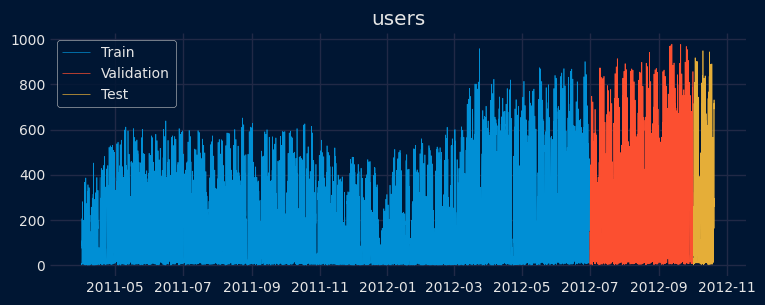

In [5]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['users'], label='Train')
ax.plot(data_val['users'], label='Validation')
ax.plot(data_test['users'], label='Test')
ax.set_title('users')
ax.legend();

## Intervals with In-sample residuals

By default, intervals can be computed using in-sample residuals (residuals from the training set), either by calling the `predict_interval()` method, or by performing a full [backtesting](../user_guides/backtesting.html) procedure. However, this can result in intervals that are too narrow (overly optimistic).

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Hiperparametrs used in this example have been previusly optimized using a bayesian search process. For more information about this process, please refer to: [Hyperparameter tuning and lags selection](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection).

</div>

In [6]:
# Create and fit forecaster
# ==============================================================================
params = {
    "max_depth": 7,
    "n_estimators": 300,
    "learning_rate": 0.06,
    "verbose": -1,
    "random_state": 15926
}
lags = [1, 2, 3, 23, 24, 25, 167, 168, 169]
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(**params),
                 lags            = lags,
                 window_features = window_features,
             )

forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features],
    store_in_sample_residuals = False
)

By default, `store_in_sample_residuals` is set to `False` to speed up the training process. To store in-sample residuals without retraining the model, you can call the `set_in_sample_residuals()` method and pass the training data or set `store_in_sample_residuals` to `True` when fitting the model.

In [7]:
# Store in-sample residuals in case store_in_sample_residuals = False
# ==============================================================================
forecaster.set_in_sample_residuals(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [8]:
# In-sample residuals stored during fit
# ==============================================================================
print("Amount of residuals stored:", len(forecaster.in_sample_residuals_))
forecaster.in_sample_residuals_

Amount of residuals stored: 10000


array([ 42.02327339,  -4.75342728, -39.26777553, ...,  -3.54886809,
       -41.20842177, -13.42207696])

The `backtesting_forecaster()` function is used to estimate the prediction intervals for the entire test set. Few arguments are required to use this function:

+ `use_in_sample_residuals`: If `True`, the in-sample residuals are used to compute the prediction intervals. Since these residuals are obtained from the training set, they are always available, but usually lead to overoptimistic intervals. If `False`, the out-sample residuals are used to calculate the prediction intervals. These residuals are obtained from the validation set and are only available if the `set_out_sample_residuals()` method has been called. It is recommended to use out-sample residuals to achieve the desired coverage.

+ The `interval` argument indicates the quantiles used to calculate the prediction intervals. For example, if the 10th and 90th percentiles are used, the resulting prediction intervals will have a nominal coverage of 80%.

+ `interval_method` is used to specify the method used to calculate the prediction intervals. In this case, the `bootstrapped` method is used but other methods are available.

+ The `n_boot` argument is used to specify the number of bootstrap samples to be used in estimating the prediction intervals. The larger the number of samples, the more accurate the prediction intervals will be, but the longer the calculation will take.

In [9]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False
                      )
predictions.head(5)

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

Predicted interval coverage: 61.84 %
Area of the interval: 43177.89


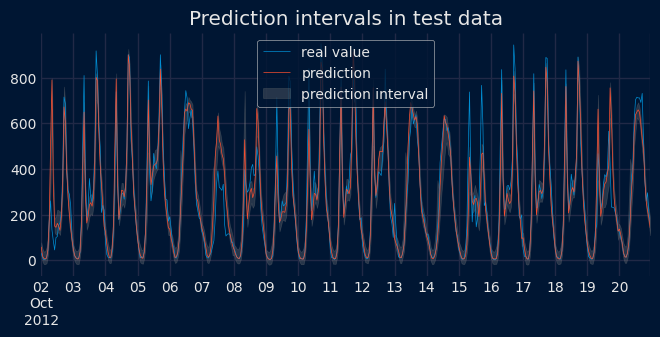

In [ ]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_validation:, 'users'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The prediction intervals show overconfidence as they tend to be too narrow, resulting in a true coverage well below the nominal coverage of 80%. This phenomenon is due to the tendency of the in-sample residuals to often overestimate the predictive ability of the model.

In [ ]:
# Store results for later comparison
# ==============================================================================
predictions_in_sample_residuals = predictions.copy()

## Out-sample residuals (non-conditioned on predicted values)

To address the issue of overoptimistic intervals, it is possible to use out-sample residuals (residuals from a validation set not seen during training) to estimate the prediction intervals. These residuals can be obtained through backtesting.

In [ ]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_validation, 'users'],
                         exog          = data.loc[:end_validation, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error'
                     )

  0%|          | 0/93 [00:00<?, ?it/s]

positive    1297
negative     935
Name: count, dtype: int64


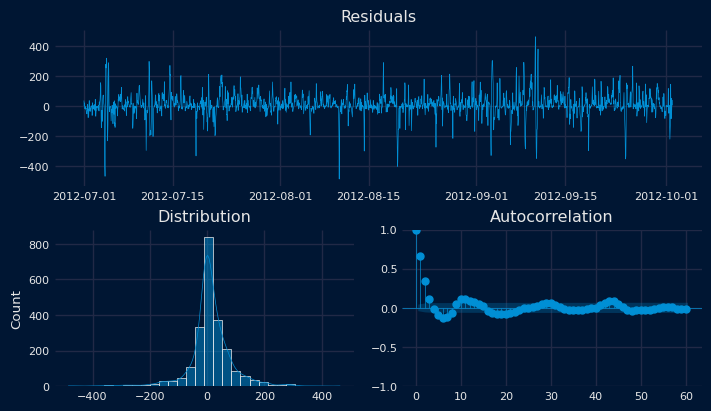

In [ ]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

With the `set_out_sample_residuals()` method, the out-sample residuals are stored in the forecaster object so that they can be used to calibrate the prediction intervals.

In [ ]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'], 
    y_pred = predictions_val['pred']
)

Now that the new residuals have been added to the forecaster, the prediction intervals can be calculated using `use_in_sample_residuals = False`.

In [ ]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = False
                      )
predictions.head(5)

  0%|          | 0/19 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-10-02 00:00:00,58.387527,30.961801,133.296285
2012-10-02 01:00:00,17.870302,-14.031592,132.635745
2012-10-02 02:00:00,7.901576,-32.265023,142.360525
2012-10-02 03:00:00,5.414332,-32.495340,167.312462
2012-10-02 04:00:00,10.379630,-13.725526,252.174056


Predicted interval coverage: 83.33 %
Area of the interval: 101257.22


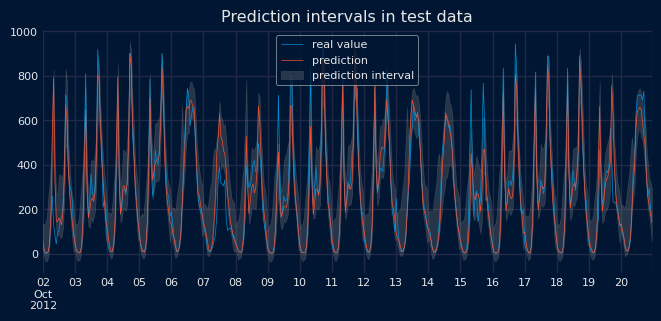

In [ ]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_validation:, 'users'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The resulting prediction intervals derived from the out-sample residuals are wider than those generated using the in-sample residuals. This results in an empirical coverage that is closer to the nominal coverage of 80%.

By zooming in on the plot, the reader will notice that the intervals are particularly wide when the predicted values are low, indicating that the model is not able to properly localize the uncertainty of its predictions.

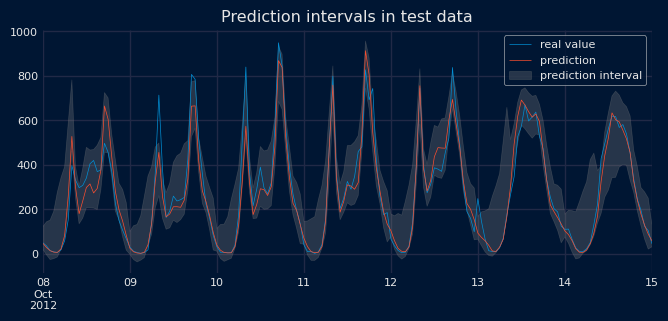

In [ ]:
# Plot intervals zoomed in ["2012-10-08 00:00:00", "2012-10-15 00:00:00"]
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    initial_x_zoom  = ["2012-10-08 00:00:00", "2012-10-15 00:00:00"],
    target_variable = "users",
    title           = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

In [ ]:
# Store results for later comparison
# ==============================================================================
predictions_out_sample_residuals = predictions.copy()

## Intervals conditioned on predicted values (binned residuals)

The bootstrapping process assumes that the residuals are independently distributed so that they can be used independently of the predicted value. In reality, this is rarely true; in most cases, the magnitude of the residuals is correlated with the magnitude of the predicted value. In this case, for example, one would hardly expect the error to be the same when the predicted number of users is close to zero as when it is in the hundreds.

To account for the dependence between the residuals and the predicted values, skforecast allows to **partition the residuals into *K* bins**, where each bin is associated with a range of predicted values. Using this strategy, the bootstrapping process samples the residuals from different bins depending on the predicted value, which can improve the coverage of the interval while adjusting the width if necessary, allowing the model to **better distribute the uncertainty of its predictions**.

Internally, skforecast uses a [`QuantileBinner`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.QuantileBinner) class to bin data into quantile-based bins using `numpy.percentile`. This class is similar to [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) but faster for binning data into quantile-based bins. Bin intervals are defined following the convention: bins[i-1] <= x < bins[i]. The binning process can be adjusted using the argument `binner_kwargs` of the Forecaster object.

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor     = LGBMRegressor(**params),
                 lags          = lags,
                 binner_kwargs = {'n_bins': 10}   
             )

forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features],
    store_in_sample_residuals = True
)

During the training process, the forecaster uses the in-sample predictions to define the intervals at which the residuals are stored depending on the predicted value to which they are related (`binner_intervals_` attribute). 

Although not used in this example, the in-sample residuals are divided into bins and stored in the `in_sample_residuals_by_bin_` attribute.

In [ ]:
# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals_)

{0: (-0.8943794883271247, 10.608406827878845),
 1: (10.608406827878845, 30.676160623625577),
 2: (30.676160623625577, 74.1882217425986),
 3: (74.1882217425986, 120.49652689276296),
 4: (120.49652689276296, 164.97690978552197),
 5: (164.97690978552197, 209.69596300954962),
 6: (209.69596300954962, 268.3808557231679),
 7: (268.3808557231679, 338.3331511270013),
 8: (338.3331511270013, 460.65535040899925),
 9: (460.65535040899925, 955.802117392104)}


In [ ]:
# Number of in-sample residuals by bin
# ==============================================================================
for k, v in forecaster.in_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=1000
Bin 1: n=1000
Bin 2: n=1000
Bin 3: n=1000
Bin 4: n=1000
Bin 5: n=1000
Bin 6: n=1000
Bin 7: n=1000
Bin 8: n=1000
Bin 9: n=1000


The `set_out_sample_residuals()` method will bin the residuals according to the intervals learned during fitting. To avoid using too much memory, the number of residuals stored per bin is limited to `10_000 // self.binner.n_bins_`. The predictions obtained in the backtesting are used.

In [ ]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'], 
    y_pred = predictions_val['pred']
)

In [ ]:
# Number of out-sample residuals by bin
# ==============================================================================
for k, v in forecaster.out_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=153
Bin 1: n=168
Bin 2: n=197
Bin 3: n=118
Bin 4: n=153
Bin 5: n=157
Bin 6: n=232
Bin 7: n=302
Bin 8: n=318
Bin 9: n=434


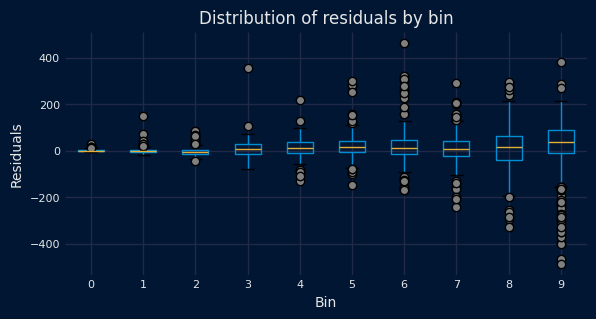

In [ ]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict(
        [(k, pd.Series(v))
         for k, v in forecaster.out_sample_residuals_by_bin_.items()]
    )
)
fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=6),
    ax=ax
)
ax.set_title("Distribution of residuals by bin", fontsize=12)
ax.set_xlabel("Bin", fontsize=10)
ax.set_ylabel("Residuals", fontsize=10)
plt.show();

The box plots show how the spread and magnitude of the residuals differ depending on the predicted value. The residuals are more dispersed when the predicted value is higher (higher bin), which is consistent with the intuition that errors tend to be larger when the predicted value is larger.

Finally, the prediction intervals estimated again, this time using out-sample residuals conditioned on the predicted values.

In [ ]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,   # Residuals conditioned on predicted values
                      )
predictions.head(3)

  0%|          | 0/19 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-10-02 00:00:00,60.399647,40.609922,75.876519
2012-10-02 01:00:00,17.617464,5.186247,38.272262
2012-10-02 02:00:00,9.002365,4.862337,29.131771


Predicted interval coverage: 85.96 %
Area of the interval: 96214.57


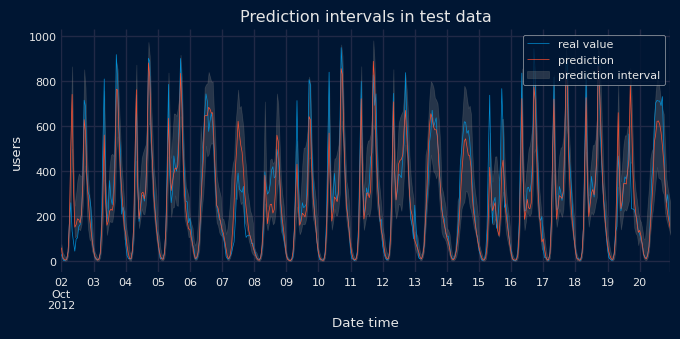

In [ ]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    xaxis_title         = "Date time",
    yaxis_title         = "users",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_validation:, 'users'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

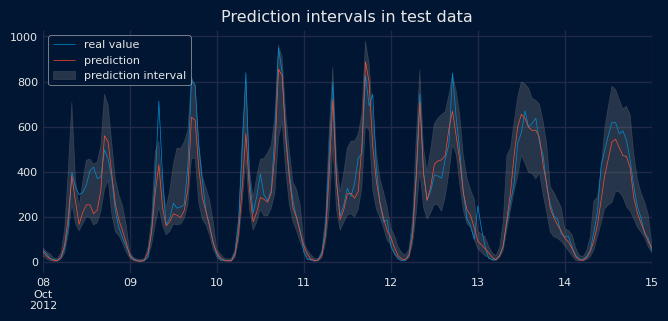

In [ ]:
# Plot intervals zoomed in ["2012-10-08 00:00:00", "2012-10-15 00:00:00"]
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    initial_x_zoom      = ["2012-10-08 00:00:00", "2012-10-15 00:00:00"],
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

When using out-sample residuals conditioned on the predicted value, the area of the interval is significantly reduced and the uncertainty is mainly allocated to the predictions with high values. However, the empirical coverage is still above the expected coverage, which means that the estimated intervals are conservative.

The follwing plot compares the prediction intervals obtained using in-sample residuals, out-sample residuals, and out-sample residuals conditioned on the predicted values.

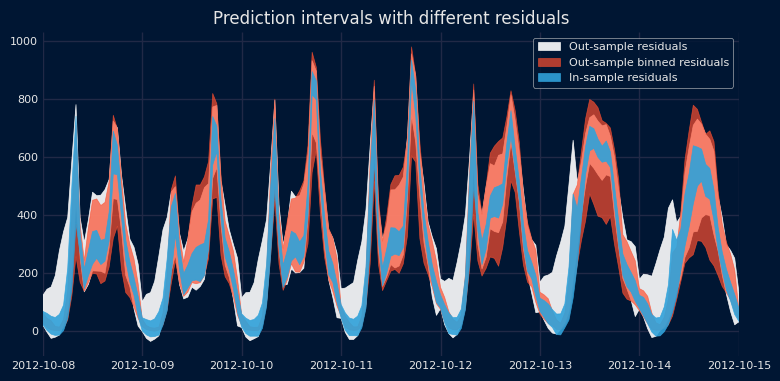

In [ ]:
# Plot intervals using: in-sample residuals, out-sample residuals and binned residuals
# ==============================================================================
predictions_out_sample_residuals_binned = predictions.copy()
fig, ax = plt.subplots(figsize=(8, 4))
ax.fill_between(
    data_test.index,
    predictions_out_sample_residuals["lower_bound"],
    predictions_out_sample_residuals["upper_bound"],
    color='white',
    alpha=0.9,
    label='Out-sample residuals',
    zorder=1
)
ax.fill_between(
    data_test.index,
    predictions_out_sample_residuals_binned["lower_bound"],
    predictions_out_sample_residuals_binned["upper_bound"],
    color='#fc4f30',
    alpha=0.7,
    label='Out-sample binned residuals',
    zorder=2
)

ax.fill_between(
    data_test.index,
    predictions_in_sample_residuals["lower_bound"],
    predictions_in_sample_residuals["upper_bound"],
    color='#30a2da',
    alpha=0.9,
    label='In-sample residuals',
    zorder=3
)
ax.set_xlim(pd.to_datetime(["2012-10-08 00:00:00", "2012-10-15 00:00:00"]))
ax.set_title("Prediction intervals with different residuals", fontsize=12)
ax.legend();

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
<b>Probabilistic forecasting in production</b>

The correct estimation of prediction intervals with bootstrapped residuals depends on the residuals being representative of future errors. For this reason, out-of-sample residuals should be used. However, the dynamics of the series and models can change over time, so it is important to monitor and regularly update the residuals. It can be done easily using the <code>set_out_sample_residuals()</code> method.
</p>

</div>

## Prediction of multiple intervals

The `backtesting_forecaster` function not only allows to estimate a single prediction interval, but also to estimate multiple quantiles (percentiles) from which multiple prediction intervals can be constructed. This is useful to evaluate the quality of the prediction intervals for a range of probabilities. Furthermore, it has almost no additional computational cost compared to estimating a single interval.

Next, several percentiles are predicted and from these, prediction intervals are created for different nominal coverage levels - 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% and 95% - and their actual coverage is assessed.

In [ ]:
# Prediction intervals for different nominal coverages
# ==============================================================================
quantiles = [2.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97.5]
intervals = [[2.5, 97.5], [5, 95], [10, 90], [15, 85], [20, 80], [30, 70], [35, 65], [40, 60], [45, 55]]
observed_coverages = []
observed_areas = []

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = quantiles,
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True
                      )
predictions.head()

  0%|          | 0/19 [00:00<?, ?it/s]

,pred,p_2.5,p_5,p_10,p_15,p_20,p_25,p_30,p_35,p_40,...,p_55,p_60,p_65,p_70,p_75,p_80,p_85,p_90,p_95,p_97.5
2012-10-02 00:00:00,60.399647,26.892402,33.951113,40.609922,42.760696,44.244359,46.570077,48.923822,49.785492,50.587951,...,55.370331,57.151158,58.458595,59.347441,61.621755,65.284405,69.355807,75.876519,86.239833,120.265754
2012-10-02 01:00:00,17.617464,2.689591,3.512207,5.186247,6.486508,8.169985,9.041067,9.761858,10.572733,11.359216,...,17.526959,19.567121,20.340357,23.363116,25.280020,29.001507,33.544834,38.272262,51.626343,71.371264
2012-10-02 02:00:00,9.002365,1.437432,2.099155,4.862337,5.415269,6.460628,6.985618,7.847532,8.239015,8.931894,...,11.559812,12.799507,13.812258,14.086847,15.113970,16.543545,20.604941,29.131771,35.799777,49.683165
2012-10-02 03:00:00,5.306644,-0.465970,1.157744,2.417394,3.083630,3.739066,4.018527,4.467039,5.003059,5.384454,...,6.667717,7.496738,8.055827,8.567819,9.560928,10.495075,12.231564,14.223768,19.437481,23.503909
2012-10-02 04:00:00,9.439573,-0.401817,2.997039,4.808793,5.552889,6.464636,6.875786,8.056258,8.496770,9.126208,...,10.863024,11.754925,12.132281,12.877582,13.524530,15.188979,18.552166,25.501337,30.655910,47.941695


In [ ]:
# Calculate coverage and area for each interval
# ==============================================================================
for interval in intervals:
    observed_coverage = calculate_coverage(
                            y_true      = data.loc[end_validation:, 'users'],
                            lower_bound = predictions[f"p_{interval[0]}"], 
                            upper_bound = predictions[f"p_{interval[1]}"]
                        )
    observed_area = (predictions[f"p_{interval[1]}"] - predictions[f"p_{interval[0]}"]).sum()
    observed_coverages.append(100 * observed_coverage)
    observed_areas.append(observed_area)

results = pd.DataFrame({
              'Interval': intervals,
              'Nominal coverage': [interval[1] - interval[0] for interval in intervals],
              'Observed coverage': observed_coverages,
              'Area': observed_areas
          })
results.round(1)

,Interval,Nominal coverage,Observed coverage,Area
0,"[2.5, 97.5]",95.0,96.5,164395.6
1,"[5, 95]",90.0,93.6,131727.4
2,"[10, 90]",80.0,86.0,96214.6
3,"[15, 85]",70.0,80.3,74675.2
4,"[20, 80]",60.0,72.4,58774.0
5,"[30, 70]",40.0,50.0,34625.7
6,"[35, 65]",30.0,37.7,25213.9
7,"[40, 60]",20.0,26.8,16243.0
8,"[45, 55]",10.0,14.3,8069.0


## Predict boostrap, interval, quantile and distribution

The previous sections have demonstrated the use of the backtesting process to estimate the prediction interval over a given period of time. The goal is to mimic the behavior of the model in production by running predictions at regular intervals, incrementally updating the input data.

Alternatively, it is possible to run a single prediction that forecasts *N* steps ahead without going through the entire backtesting process. In such cases, skforecast provides four different methods: `predict_bootstrapping`, `predict_interval`, `predict_quantile` and `predict_distribution`.

If the user needs to run a backtesting process using one of these prediction methods, the `interval` argument of `backtesting_forecaster()` can be specified as:

- If `list` or `tuple`: Sequence of percentiles to compute, each value must be between 0 and 100 inclusive. For example, a 95% confidence interval can be specified as `interval = [2.5, 97.5]` or multiple percentiles (e.g. 10, 50 and 90) as `interval = [10, 50, 90]`.

- If `'bootstrapping'` (str): `n_boot` bootstrapping predictions will be generated.

- If `scipy.stats distribution object`, the distribution parameters will be estimated for each prediction.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

All of these methods can be used either with in-sample or out-sample residuals using the <code>use_in_sample_residuals</code> argument, and with binned intervals conditioned on predicted values using the <code>use_binned_residuals</code> argument.

</div>

**Predict Bootstraping** 

The `predict_bootstrapping` method performs the `n_boot` bootstrapping iterations that generate the alternative prediction paths. These are the underlying values used to compute the intervals, quantiles, and distributions.

In [ ]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(**params),
                 lags      = lags
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features],
    store_in_sample_residuals = True
)

In [ ]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       exog   = data_test[exog_features],
                       steps  = 7,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2012-10-02 00:00:00,88.879247,78.246636,49.984869,69.577690,51.915378,68.122753,102.705706,81.746083,53.560382,61.004076,...,68.726941,52.789489,111.814563,60.801714,37.641149,52.365132,67.545112,56.850166,59.111774,72.659410
2012-10-02 01:00:00,57.657081,25.033177,31.180144,36.780890,19.035948,26.866682,45.984298,20.355401,5.630827,10.945272,...,22.270334,21.766025,56.963715,48.210861,18.708850,15.789584,30.696750,19.456578,29.765112,4.228910
2012-10-02 02:00:00,12.887268,5.790686,29.702349,22.591337,11.045785,16.674854,18.753101,12.973743,3.777229,12.169120,...,4.296488,4.401613,33.874989,15.179147,13.363857,5.768846,13.762247,7.355377,13.646284,5.185202
2012-10-02 03:00:00,1.325881,13.426438,5.424700,10.264177,2.517472,10.174256,3.838419,5.269279,3.745842,8.711563,...,3.619119,7.233575,29.524688,4.340874,1.395143,3.450817,11.356415,1.752098,6.295690,9.212573
2012-10-02 04:00:00,5.937973,18.340258,7.026383,6.458254,9.293808,6.658706,5.311346,8.926221,19.061047,11.069167,...,4.862457,9.439351,12.752172,8.151417,13.346762,9.430721,4.569697,10.416891,4.205799,12.035805
2012-10-02 05:00:00,45.659352,63.113540,22.249161,49.934912,44.016236,45.043004,32.716709,36.549307,45.088503,36.769994,...,36.914090,44.082305,49.725989,15.250112,29.838267,69.812061,43.924128,66.655251,35.331056,60.768929
2012-10-02 06:00:00,176.606958,167.161502,120.994701,160.371600,197.391862,172.208403,140.714691,178.605939,154.379688,186.232511,...,210.301702,156.894027,186.531477,104.184214,120.640401,172.695645,230.795897,170.612954,137.477798,188.347698


A ridge plot is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

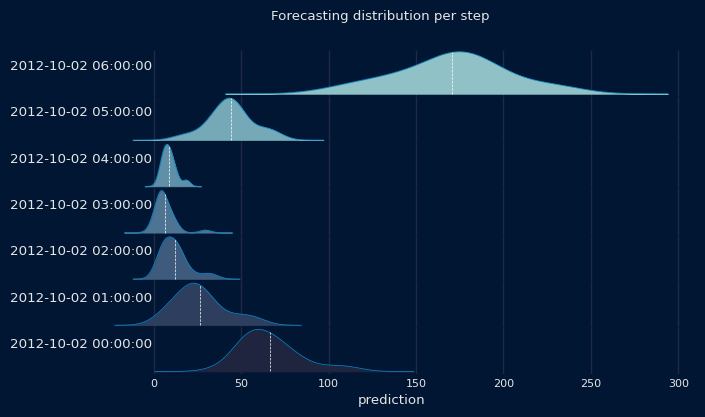

In [ ]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

**Predict Interval**

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [ ]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(
                  steps    = 7,
                  exog     = data_test[exog_features],
                  method   = 'bootstrapping',
                  interval = [10, 90],
                  n_boot   = 150
              )
predictions

,pred,lower_bound,upper_bound
2012-10-02 00:00:00,60.399647,42.568278,77.238528
2012-10-02 01:00:00,17.617464,6.978055,31.694925
2012-10-02 02:00:00,9.002365,3.421961,17.410508
2012-10-02 03:00:00,5.306644,1.326573,9.876715
2012-10-02 04:00:00,9.439573,4.638031,17.298454
2012-10-02 05:00:00,43.867127,29.845118,62.169581
2012-10-02 06:00:00,177.677903,131.161491,206.197206


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

The <code>predict_interval</code> method can also be used to estimate the conformal prediction intervals using the argument <code>method = 'conformal'</code>. For more information, check out the following user guide:

<a href="../user_guides/probabilistic-forecasting-conformal-prediction.html" target="_blank"> Probabilistic Forecasting: Conformal Prediction </a>

</div>

**Predict Quantile**

This method operates identically to `predict_interval`, with the added feature of enabling users to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the range of 0 to 1.

In [ ]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(
                  steps     = 7,
                  exog      = data_test[exog_features],
                  quantiles = [0.05, 0.25, 0.75, 0.95],
                  n_boot    = 150,
              )
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2012-10-02 00:00:00,36.652268,49.990237,67.536451,84.482214
2012-10-02 01:00:00,4.379827,12.421828,24.280527,38.289425
2012-10-02 02:00:00,2.445470,5.770482,11.869983,23.834125
2012-10-02 03:00:00,0.630186,3.124967,7.398633,13.196140
2012-10-02 04:00:00,3.665995,6.898361,11.656924,21.140225
2012-10-02 05:00:00,20.394163,37.323977,52.703749,69.742087
2012-10-02 06:00:00,108.153371,151.683616,195.516798,233.237341


**Predict Distribution**

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [ ]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
predictions = forecaster.predict_dist(
                  steps        = 7,
                  exog         = data_test[exog_features],
                  method       = 'bootstrapping',
                  distribution = norm,
                  n_boot       = 150
              )
predictions

TypeError: ForecasterRecursive.predict_dist() got an unexpected keyword argument 'method'

All these types of predictions can be generated with a backtesting process. The `interval` argument in the `backtesting_forecaster` is the one that determines this output:

+ `interval = "bootstrapping"`: to generate the entire bootstrapping matrix.

+ List of two percentiles: to generate the prediction intervals. For example, `interval = [2.5, 97.5]`.

+ List of more than two percentiles: to generate the prediction for each quantile (percentile). For example, `interval = [10, 50, 90]`.

+ A scipy.stats distribution: to generate the distribution parameters. For example, `interval = scipy.stats.norm`.